### MNIST - Reconhecer numeros escritos a mao

Obejetivo reconhcer numeros escrito a mao para solucoes de problemas especificos como da Amazon

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [3]:
transform = transforms.ToTensor() # definindo a conversao de imagem do tensor
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # cria um buffer para pegar os dados por partes (gerador)


valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # carrega a parte de validacao do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # cria um buffer para pegar os dados por partes

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.90MB/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



### Verificando uma imagem aleatoria para validar se os dados foram carregados

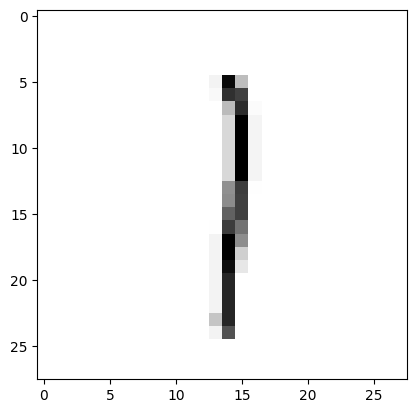

In [6]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

### Verificando as dimensoes do tensor de cada imagem

In [7]:
print(imagens[0].shape)
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


### Iniciando a RNA (https://keras.io/api/applications/)

In [11]:
class Modelo(nn.Module):
  def __init__(self):
    super (Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10
    # para a camada de saida não e necessário definir nada pois só precisamos pegar o output da camada interna 2


  def forward(self,X):
    X = F.relu(self.linear1(X)) # funcão de ativação da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X) # funcão de ativação da camada interna 2 para a camada de saida, nesse caso f(x)
    return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

### Treinamento

In [12]:
def treino(modelo, trainloader, device):
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # otimizador
  inicio = time() # pega o tempo inicial

  criterio = nn.NLLLoss() # função de perda
  EPOCHS = 10
  modelo.train() # ativando o modo de treinamento

  for epoch in range(EPOCHS):
    perda_acumulada = 0.0 # inicializacao da perda acumulada em questao

    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1) # transformando a imagem para vetores de 28*28 casas para ficarem compativeis com a
      otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) # colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questao

      perda_instantanea.backward() # back propagation a partir da perda

      otimizador.step() # atualizando os pesos e a bias

      perda_acumulada += perda_instantanea.item() # atualizando a perda acumulada

    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))

  print("Tempo de treino (em minutos) =",(time()-inicio)/60)

In [14]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      # desativar o autoarmazenamento
      with torch.no_grad():
        logps = modelo(img.to(device)) # output do modelo em escala logaritmica

      ps = torch.exp(logps) # converte o output do modelo em escala linear lembrando que e um tensor
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) # converte o tensor em um numero, no caso o numero que o modelo previu como correto
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred):
        conta_corretas += 1
      conta_todas += 1

  print("Total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))




In [15]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)